# Práctica: Perceptron vs Perceptron Pocket
### Itzanami Berlanga Contreras
07 de Abril del 2024
Inteligencia Artificial | Universidad de Guanajuato 

En esta práctica implementamos el algoritmo del perceptrón para un problema de clasificación binaria sobre el conjunto de datos de Iris Plant tomando en cuenta para esto las clases versicolor y virginica, las cuales no son linealmente separables, y considerando las características del ancho y largo del sepalo.

## Carga de Datos

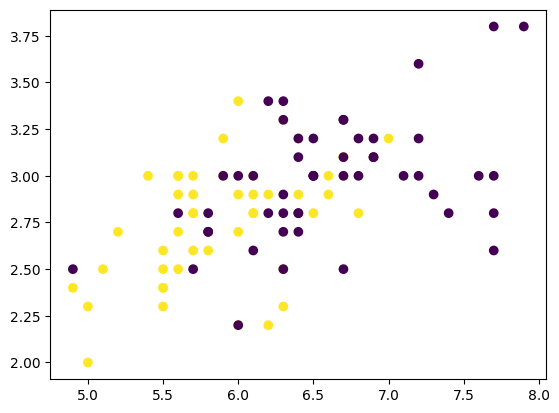

In [208]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

#carga del conjunto de datos
X,y = load_iris(return_X_y=True)

#filtrado de características y etiquetas de clase
X = X[y!=0, 0:2]
y = y[y!=0]
y[y==2] = 0

#grafica del conjunto de datos
plt.scatter(X[:,0], X[:,1], c = y)
plt.show()

## División del conjunto de datos en entrenamiento y prueba y escalamiento

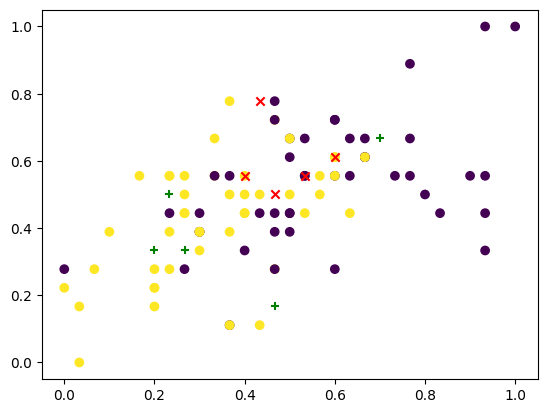

In [209]:
from sklearn.model_selection import train_test_split

#división del conjunto de datos y escalamiento de los datos
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1, stratify=y)
escalador = MinMaxScaler()
X_tr = escalador.fit_transform(X_tr)
X_te = escalador.transform(X_te)

#grafica del conjunto de datos escalados y divididos
plt.scatter(X_tr[:,0], X_tr[:,1], c = y_tr)
plt.scatter(X_te[y_te == 0,0], X_te[y_te == 0,1], marker='x', c = 'red')
plt.scatter(X_te[y_te == 1,0], X_te[y_te == 1,1], marker='+', c = 'green')
plt.show()

## Perceptron con regla de aprendizaje estándar

In [210]:
#Implemente el algoritmo de Perceptron (método de entrenamiento y prueba)
class Perceptron:
    def __init__(self, epocas):
        self.epocas = epocas
    
    def train(self, X_tr, Y_tr):
        # Vector extendido
        ext = np.ones((len(Y_tr), 1))
        self.X_tr = np.append(X_tr, ext, axis = 1)
        
        self.Y_tr = Y_tr
        self.w = [-0.5, 0.5, 0]     # Vector de pesos
        self.t = 0                  # Cantidad de cambios
        
        ''' Entrenamiento: Sea pp el producto punto de w con x_i, si
            - Si y = 1, pp > 0, continua
            - Si y = 1, pp < 0, suma
            - Si y = 0, pp > 0, resta
            - Si y = 0, pp < 0, continua
        '''
        for ep in range(1, self.epocas):
            for i in range(len(self.X_tr)):
                pp = np.dot(self.X_tr[i], self.w)
                if pp < 0 and self.Y_tr[i] == 1:  # Suma
                    self.w = self.w + self.X_tr[i]
                    self.t = self.t + 1
                if pp > 0 and self.Y_tr[i] == 0:  # Resta
                    self.w = self.w - self.X_tr[i]
                    self.t = self.t + 1
    
    def predict(self, X_test):
        # Vector extendido
        ext = np.ones((len(X_test), 1))
        X_test = np.append(X_test, ext, axis = 1)
        
        Y_test = np.zeros(len(X_test))
        for i in range(len(X_test)):
            pp = np.dot(X_test[i], self.w)
            if pp >= 0:
                Y_test[i] = 1
        return Y_test
    
    def evaluate(self, X_test, Y_test):
        Y_pred = self.predict(X_test)
        exitos = 0
        for i in range(len(Y_test)):
            if Y_test[i] == Y_pred[i]:
                exitos += 1
        return exitos/len(Y_test)
    
    def peso(self):
        return  self.w

## Perceptron con regla de aprendizaje de bolsillo

In [211]:
#Implemente el algoritmo de Pocket (método de entrenamiento y prueba)

class PerceptronPocket:
    def __init__(self, epocas):
        self.epocas = epocas
    
    def __evaluarModelo(self, w):
        exitos = 0
        for i in range(len(self.X_tr)):
            pp = np.dot(self.X_tr[i], w)
            if (pp >= 0 and self.Y_tr[i] == 1) or (pp < 0 and self.Y_tr[i] == 0):
                exitos += 1
        return exitos/len(self.Y_tr)
    
    def train(self, X_tr, Y_tr):
        # Vector extendido
        ext = np.ones((len(Y_tr), 1))
        self.X_tr = np.append(X_tr, ext, axis = 1)
        
        self.Y_tr = Y_tr
        self.w_hist = [-0.5, 0.5, 0]                                 # Mejor peso historico
        w_act = [-0.5, 0.5, 0]                                       # Peso actual sobre el que se hacen las modificaciones del perceptron
        self.succ_hist = self.__evaluarModelo(self.w_hist)          # Tasa de exito del mejor peso historico
        self.t = 0                                                  # Cantidad de cambios
        ''' Entrenamiento: Sea pp el producto punto de w_act con X_tr[i], si
            - Si y = 1, pp > 0, continua
            - Si y = 1, pp < 0, suma
            - Si y = 0, pp > 0, resta
            - Si y = 0, pp < 0, continua
        '''
        for ep in range(1, self.epocas):
            # Procedimiento normal del perceptron
            for i in range(len(self.X_tr)):
                w_ant = w_act
                pp = np.dot(self.X_tr[i], w_act)
                if pp < 0 and self.Y_tr[i] == 1:  # Suma
                    w_act = w_act + self.X_tr[i]
                    self.t = self.t + 1
                if pp > 0 and self.Y_tr[i] == 0:  # Resta
                    w_act = w_act - self.X_tr[i]
                    self.t = self.t + 1
                    
                # Despues de hacer la verificacion correspondiente, verificar si se hicieron modificaciones 
                # y en dicho caso evaluar si hay una mejora en la tasa de exito comparada con el mejor historico
                if not ((np.array(w_act) == np.array(w_ant)).all()):
                    succ_actual = self.__evaluarModelo(w_act)
                    if succ_actual > self.succ_hist:
                        self.w_hist = w_act
                        self.succ_hist = succ_actual
    
    def predict(self, X_test):
        # Vector extendido
        ext = np.ones((len(X_test), 1))
        X_test = np.append(X_test, ext, axis = 1)
        
        Y_test = np.zeros(len(X_test))
        for i in range(len(X_test)):
            pp = np.dot(X_test[i], self.w_hist)
            if pp >= 0:
                Y_test[i] = 1
        return Y_test
    
    def evaluate(self, X_test, Y_test):
        Y_pred = self.predict(X_test)
        exitos = 0
        for i in range(len(Y_test)):
            if Y_test[i] == Y_pred[i]:
                exitos += 1
        return exitos/len(Y_test)
    
    def peso(self):
        return  self.w_hist

## Resultados y gráfica de los perceptrones

La exactitud del perceptron en el conjunto de entrenamiento fue 0.6333333333333333
La exactitud del perceptron en el conjunto de prueba fue 0.5
La exactitud del perceptron pocket en el conjunto de entrenamiento fue 0.7444444444444445
La exactitud del perceptron pocket en el conjunto de prueba fue 0.7


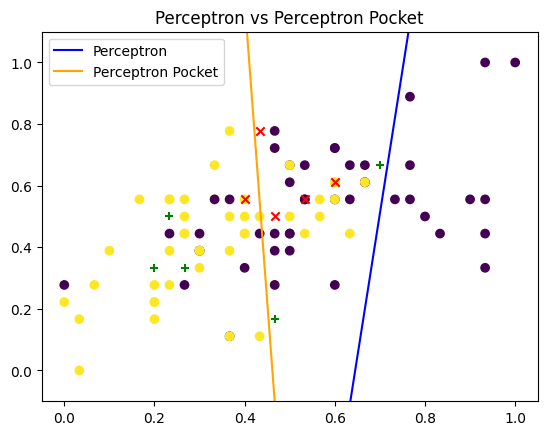

'\nTODO\n-Entrenamiento de perceptron (con regla de aprendizaje estándar)\n-Entrenamiento de perceptron (con regla de aprendizaje pocket)\n-Graficar ambas rectas de resultado en el problema original usando diferentes colores para cada solución del peceptron\n-Obtener exactitud para entrenamiento de ambos modelos\n-Obtener exactitud para prueba de ambos modelos\n'

In [212]:
#Comparación de reglas de aprendizaje
epocas = 100

# Entrenamiento y exactitud del perceptron 
percep = Perceptron(epocas)
percep.train(X_tr, y_tr)
print(f"La exactitud del perceptron en el conjunto de entrenamiento fue {percep.evaluate(X_tr, y_tr)}")
print(f"La exactitud del perceptron en el conjunto de prueba fue {percep.evaluate(X_te, y_te)}")

# Entrenamiento y exactitud del perceptron pocket
percePocket = PerceptronPocket(epocas)
percePocket.train(X_tr, y_tr)
print(f"La exactitud del perceptron pocket en el conjunto de entrenamiento fue {percePocket.evaluate(X_tr, y_tr)}")
print(f"La exactitud del perceptron pocket en el conjunto de prueba fue {percePocket.evaluate(X_te, y_te)}")

# Conjunto de datos
plt.scatter(X_tr[:,0], X_tr[:,1], c = y_tr)
plt.scatter(X_te[y_te == 0,0], X_te[y_te == 0,1], marker='x', c = 'red')
plt.scatter(X_te[y_te == 1,0], X_te[y_te == 1,1], marker='+', c = 'green')

# Recta del perceptron
w_perc = percep.peso()
x_perc = np.linspace(0, 1, 100)
y_perc = -w_perc[2]/w_perc[1] - w_perc[0]*x_perc/w_perc[1]
plt.plot(x_perc, y_perc, color = 'blue', label = 'Perceptron')

# Recta del perceptron pocket
w_percPock = percePocket.peso()
x_percPock = np.linspace(0, 1, 100)
y_percPock = -w_percPock[2]/w_percPock[1] - w_percPock[0]*x_percPock/w_percPock[1]
plt.plot(x_percPock, y_percPock, color = 'orange', label = 'Perceptron Pocket')

plt.legend()
plt.title("Perceptron vs Perceptron Pocket")
plt.ylim(-0.1, 1.1)

plt.show()

'''
TODO
-Entrenamiento de perceptron (con regla de aprendizaje estándar)
-Entrenamiento de perceptron (con regla de aprendizaje pocket)
-Graficar ambas rectas de resultado en el problema original usando diferentes colores para cada solución del peceptron
-Obtener exactitud para entrenamiento de ambos modelos
-Obtener exactitud para prueba de ambos modelos
'''